In [ ]:
import os

import pickle
import random
import numpy as np
np.set_printoptions(formatter={'float_kind':(lambda x: "%6.2f" % x)})

import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

import importlib

In [ ]:
#import argparse
#parser = argparse.ArgumentParser(
#            description='PyTorch Relations-from-Stream sort-of-CLVR Example')
#args = parser.parse_args()

from attrdict import AttrDict
args = AttrDict()

In [ ]:
torch.cuda.is_available()

In [ ]:
args.batch_size = 32
args.cuda = torch.cuda.is_available()
args.lr   = 0.0001
args.seed = 5
args.process_coords=False
args.debug = True
args.rnn_hidden_size = 32

In [ ]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [ ]:
# Load in a batch of images to test dimensions, etc...
bs = args.batch_size

input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 11)
label = torch.LongTensor(bs)

if args.cuda:
    input_img = input_img.cuda()
    input_qst = input_qst.cuda()
    label = label.cuda()
    
input_img = Variable(input_img)
input_qst = Variable(input_qst)
label = Variable(label)

In [ ]:
data_dirs = './data'

filename = os.path.join(data_dirs, 'sort-of-clevr++.pickle')
with open(filename, 'rb') as f:
  train_datasets, test_datasets = pickle.load(f)

def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

rel_train, norel_train = [], []
for img, relations, norelations in train_datasets:
    img = np.swapaxes(img,0,2)
    for qst,ans in zip(relations[0], relations[1]):
        rel_train.append((img,qst,ans))
    for qst,ans in zip(norelations[0], norelations[1]):
        norel_train.append((img,qst,ans))

rel   = cvt_data_axis(rel_train)
norel = cvt_data_axis(norel_train)

In [ ]:
def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))

    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(qst.size()).copy_(qst)
    label.data.resize_(ans.size()).copy_(ans)

tensor_data(norel, 0)
#tensor_data(rel, 0)    # Loads batch 0 into input_img, input_qst amd label

In [157]:
def from_pytorch(p): 
    #print(type(p))
    if isinstance(p, Variable):
        return p.cpu().data.numpy()
    return p

def show_image(img):
    im = np.swapaxes( from_pytorch(img), 0,2)  # Undo the np->pytorch swap
    plt.figure(figsize=(6,6))
    plt.imshow(im[:,:,::-1], interpolation='nearest')  # BGR-> RGB
    #plt.axis('off')

colors = 'red green blue orange gray yellow'.split()
def describe_question(q):
    question = list(from_pytorch(q))
    color_arr = [colors[i] for i in range(0,6) if question[i]==1.]
    #query = colors[question[0:6].index(1)]
    query = '[%s] ' % ','.join(color_arr)

    if question[6]==1 and question[7]==0 :  # NonRel Questions
        if question[8] == 1:  query += 'shape?'
        if question[9] == 1:  query += 'left?'
        if question[10] == 1: query += 'up?'
            
    if question[6]==0 and question[7]==1:  # BiRel questions
        if question[8] == 1:  query += 'closest shape?'
        if question[9] == 1:  query += 'furthest shape?'
        if question[10] == 1: query += 'shape count?'

    if question[6]==1 and question[7]==1:  # Tricky questions
        if question[8] == 1:  query += 'big area triangle?'
        if question[9] == 1:  query += 'clockwise?'
        if question[10] == 1: query += 'most isolated shape?'
    return query

answer_sheet = ['yes', 'no', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6']
def describe_answer(a):
    answer = from_pytorch(a)[0]
    return answer_sheet[answer]

def to_array(v): return v.cpu().data.numpy()

def heat_map(d2, Xmap_to_zero=3.0):  # exp() factor below max that gets mapped to 0
    d2_np = d2[0:25].view(5,5).t().cpu().data.numpy()
    #d2_max = np.max(d2_np)
    #d2_rescale = np.maximum(0., 1.0+(d2_np-d2_max)/map_to_zero)
    print(d2_np)
    plt.figure(figsize=(4,4))
    plt.imshow(np.exp(d2_np), interpolation='nearest', cmap='gray')  # copper, binary

def show_example(i):
    print( describe_question( input_qst[i] ), describe_answer( label[i] ) )
    show_image(input_img[i])

In [ ]:
example_choice = 22
show_example(example_choice)

In [ ]:
#from model import RN, CNN_MLP, RFS
import model
importlib.reload(model)

args.process_coords=False

m = model.RFS(args)
if args.cuda:
    m.cuda()
m.train();

#accuracy_rel = m.train_(input_img, input_qst, label)
#accuracy_norel = m.train_(input_img, input_qst, label)

# Load a snapshot
#m.load_state_dict( torch.load('model/RFS_2item-span-again-seed10_050.pth') )
m.load_state_dict( torch.load('model/RFS_2item-span-again-seed10_050.pth', map_location=lambda storage, loc: storage) )

m.optimizer.zero_grad()
output = m(input_img, input_qst)

In [ ]:
print( to_array(m.ans_logits[example_choice]), 
       ' answer = %s' % answer_sheet[ np.argmax(to_array(m.ans_logits[example_choice])) ] )
for i in range(len(m.ent_similarities)):
    heat_map(m.ent_similarities[i][example_choice])
#m.ent_similarities[example_choice].size()

### Sanity checks

In [ ]:
a = torch.zeros(8, 2)
b = torch.ones(8, 7)

c = torch.cat( (a,b), 1)
c

In [ ]:
p = torch.rand( (1,5) )
p
p.expand( (6,5) )
p.expand( (6,5) ) + torch.rand( (6,5) )
#p

In [ ]:
b = torch.from_numpy( np.array([[ 1.,2.,3.], [6.,1.,4. ] ], dtype=np.float32) )
b = Variable(b)
b
torch.nn.functional.softmax(b)    # This is the expected one (probs add up to 1 along rows)
#torch.nn.functional.log_softmax(b)

In [ ]:
#model.sample_gumbel(b) 
model.gumbel_softmax_sample(b, temperature=0.4)

### Check the sort-of-CLEVR generator

area =  -346.5
[red,blue,yellow] big area triangle?
no


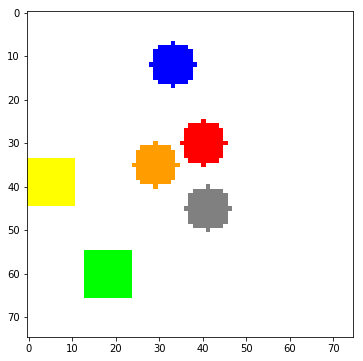

In [168]:
import sort_of_clevr_generator
importlib.reload(sort_of_clevr_generator);

(img, norelations, birelations, trirelations) = sort_of_clevr_generator.build_dataset(1)

plt.figure(figsize=(6,6))
plt.imshow(img[:,:,::-1], interpolation='nearest')  # BGR-> RGB

example_choice = 0
r = trirelations #, birelations, norelations
print( describe_question(np.array(r[0][example_choice])) )
print( describe_answer(np.array([r[1][example_choice]])) )

In [ ]:
#isinstance(np.array([]), np.ndarray)
#np.cross( np.array( [-10,-10] ), np.array( [10,10] ) )
np.linalg.norm( np.array( [10,0] ))